# Лабораторная работа №3
Классификация пингвинов
Выполнили студенты Зимин Андрей Валерьевич, Жилин Андрей Игроевич

In [131]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as rec
from sklearn.metrics import precision_score as pre
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import qrcode
import numpy as np
from matplotlib import pyplot as plt
import random
import string
from typing import Callable, List, Union
from numpy.typing import NDArray
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as rec
from sklearn.metrics import precision_score as pre
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.ticker import MaxNLocator

## Задание 1
1. Загрузить данные из файла «pinguins.csv». Проверить, что загружены все 333 кортежа данных по всем 7 признакам  
2. Определить типы данных
3. Определить параметры числовых данных
4. Для нечисловых (текстовых) данных определить количество записей по каждому элементу и визуализировать гистограммы, например, так (для признака «species»)
5. Для каждого текстового признака построить мозаику 2D диаграмм рассеяния выбирая в качестве параметров всевозможные пары числовых признаков, аналогично мозаике диаграмм для ирисов.

In [132]:
df = pd.read_csv("./data/penguins.csv")
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100,18.700,181,3750,male
1,Adelie,Torgersen,39.500,17.400,186,3800,female
2,Adelie,Torgersen,40.300,18.000,195,3250,female
3,Adelie,Torgersen,36.700,19.300,193,3450,female
4,Adelie,Torgersen,39.300,20.600,190,3650,male
...,...,...,...,...,...,...,...
328,Chinstrap,Dream,55.800,19.800,207,4000,male
329,Chinstrap,Dream,43.500,18.100,202,3400,female
330,Chinstrap,Dream,49.600,18.200,193,3775,male
331,Chinstrap,Dream,50.800,19.000,210,4100,male


Загрузили датасет. Действительно 7 признаков и 333 строки

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    int64  
 5   body_mass_g        333 non-null    int64  
 6   sex                333 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 18.3+ KB


species            - категориальный признак  
island             - категориальный признак  
bill_length_mm     - числовой признак  
bill_depth_mm      - числовой признак  
flipper_length_mm  - числовой признак  
body_mass_g        - числовой признак  
sex                - бинарный признак   

Перед обучением нужно будет закодировать категориальные признаки one-hot encoding

In [134]:
pd.options.display.float_format = '{:,.3f}'.format
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000,333.000,333.000,333.000
mean,43.993,17.165,200.967,"4,207.057"
std,5.469,1.969,14.016,805.216
min,32.100,13.100,172.000,"2,700.000"
25%,39.500,15.600,190.000,"3,550.000"
50%,44.500,17.300,197.000,"4,050.000"
75%,48.600,18.700,213.000,"4,775.000"
max,59.600,21.500,231.000,"6,300.000"


Видим, что сильно выделяется признак массы тела, он на 2-3 порядка больше остальных признаков. Перед обучением было бы неплохо провести нормализацию

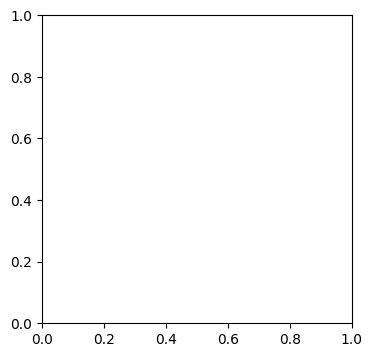

In [135]:
category_columns = ['species', 'island', 'sex']

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#for i, category in enumerate(category_columns):
#   ax[i].bar()

In [136]:
class Perceptron:
  def __init__(self, hidden_layers : List[int],
               activations: List[Callable],
               eta:Union[int, float] = 1,
               n_epochs: int = 100,
               random_weights=None,
               random_state=None):
    np.random.seed(random_state)
    random.seed(random_state)
    self.layers = []
    self.epochs = n_epochs
    self.eta = eta
    self.errors = []
    l = hidden_layers + [1]
    for i in range(len(hidden_layers)):
      self.layers.append(Layer((l[i]+1, l[i+1]), activations[i], i + 1, random_weights=random_weights))

  @staticmethod
  def relu(x):
      return np.maximum(0, x)
  @staticmethod
  def step(x):
      return x >= 0

  @staticmethod
  def shuffle(X, y):
    n = len(y)
    a = [(random.random(), X[i, :], y[i]) for i in range(n)]
    a.sort()
    new_X = np.array([a[i][1] for i in range(n)])
    new_y = np.array([a[i][2] for i in range(n)])
    return new_X, new_y

  def predict(self, train_sample: NDArray, logging: bool = False) -> NDArray:
    result = np.zeros(train_sample.shape[0])
    for i in range(train_sample.shape[0]):
      x = train_sample[i, :]
      for layer in self.layers:
        x = np.append(x, values=[1]) # добавление свободного коэффициента
        x = layer.forward(x, logging)

      result[i] = x[0]
      if logging:
        print(result[i])
    return result

  def train(self, train_sample: NDArray,
            train_ans: NDArray,
            logging=False,
            activation=np.sign,
            random_weights=None) -> list[float]:
    self.layers = [Layer((train_sample.shape[1]+1,
                          self.layers[0].size[0]-1),
                          activation,
                          0,
                          random_weights=random_weights)] + self.layers # инициализация сенсоров
    for _ in range(self.epochs):
      train_sample, train_ans = Perceptron.shuffle(train_sample, train_ans)
      error = 0
      for i in range(train_sample.shape[0]):
        x = train_sample[i, :]
        for layer in self.layers:
          x = np.append(x, values=[1]) # добавление свободного коэффициента
          x = layer.forward(x, logging)
        # вычисление ошибки
        ans = x[0]
        delta = train_ans[i] - ans
        error += abs(delta)
        # пересчет весов
        for layer in self.layers:
          layer.backward(self.eta*delta)
      self.errors.append(error)
    return self.errors


class Layer:
  def __init__(self,
               size: tuple[int, int],
               activation: Callable,
               index: int,
               value: Union[int, float]=0,
               random_weights=None):
    self.size = size
    self.w = np.full(size, value)
    if random_weights is not None:
      self.w = np.random.randint(random_weights[0], random_weights[1], self.size)
    self.activation = np.vectorize(activation)
    self.i = index
    self.last_result = np.array([])
    self.last_x = np.array([])

  def backward(self, value) -> None:
    if value > 0:
      # надо увеличить те веса, где нет активации,
      # но должна быть активация
      d = (self.last_x>0)*value
      d = np.repeat(np.array([d]).T, self.w.shape[1], axis=1)
      self.w = self.w + d
    if value < 0:
      # надо уменьшить те веса,
      # где активации быть не должно
      d = (self.last_x>0)*value
      d = np.repeat(np.array([d]).T, self.w.shape[1], axis=1)
      self.w = self.w + d

  def forward(self, x, logging) -> NDArray:
    if logging:
      print(f"Слой №{self.i+1}")
      print(f"Сенсоры  : {x}")
      print(f"Размер: {self.size}")

    m = np.dot(x, self.w)
    result = self.activation(m)
    self.last_result = result
    self.last_x = x
    if logging:
      print(f"Сумматор : {m}")
      print(f"Активация: {result}")
      print(f"Результат размера {result.shape}")

    return result

In [137]:
df.species.unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

In [138]:
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm']
X = df[numeric_features + ['sex']]
X.loc[:, 'sex'] = (X.sex == 'male')

In [139]:
y = X[['sex']].to_numpy().reshape(1, -1)[0] * 1
X = X[numeric_features].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)


In [140]:
MLP = Perceptron([400], [Perceptron.step], n_epochs=200)
errors = MLP.train(X_train, y_train , logging=False, activation=Perceptron.step, random_weights=[0, 1])

Размерность слоёв:  (5, 400) (401, 1)


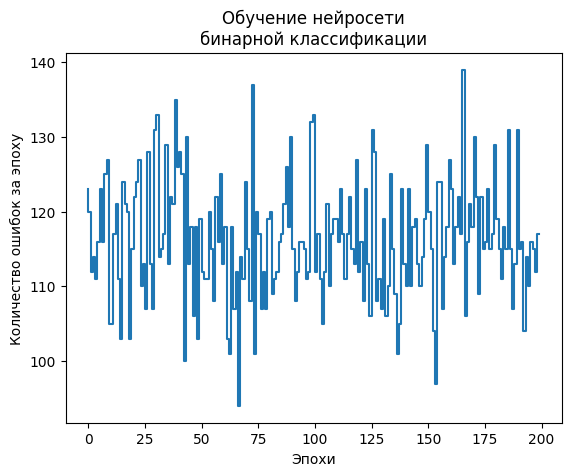

In [141]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.step([i for i in range(len(errors))], errors)

plt.xlabel("Эпохи")
plt.ylabel("Количество ошибок за эпоху")
plt.title("Обучение нейросети\nбинарной классификации")
print("Размерность слоёв: ", *[i.size for i in  MLP.layers])

In [142]:
df[df['species'] == 'Adelie']

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100,18.700,181,3750,male
1,Adelie,Torgersen,39.500,17.400,186,3800,female
2,Adelie,Torgersen,40.300,18.000,195,3250,female
3,Adelie,Torgersen,36.700,19.300,193,3450,female
4,Adelie,Torgersen,39.300,20.600,190,3650,male
...,...,...,...,...,...,...,...
141,Adelie,Dream,36.600,18.400,184,3475,female
142,Adelie,Dream,36.000,17.800,195,3450,female
143,Adelie,Dream,37.800,18.100,193,3750,male
144,Adelie,Dream,36.000,17.100,187,3700,female


In [143]:
def get_features(data, target, target_name, features):

    data = data[features + [target]]
    data.loc[:, target] = (data[target] == target_name)
    data_y = data[[target]].to_numpy().reshape(1, -1)[0] * 1
    data_x = data[numeric_features].to_numpy()

    return data_x, data_y


X1, y1, = get_features(df[df['species'] == 'Adelie'], 'sex', 'male', numeric_features)
X2, y2 = get_features(df[df['species'] == 'Gentoo'], 'sex', 'male', numeric_features)
X3, y3 = get_features(df[df['species'] == 'Chinstrap'], 'sex', 'male', numeric_features)

scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
print(X1)
X1 = scaler1.fit_transform(X1)
X2 = scaler2.fit_transform(X2)
X3 = scaler3.fit_transform(X3)
scalers = [scaler1, scaler2, scaler3]
datas = [X1, X2, X3]
targets = [y1, y2, y3]

[[  39.1   18.7 3750.   181. ]
 [  39.5   17.4 3800.   186. ]
 [  40.3   18.  3250.   195. ]
 [  36.7   19.3 3450.   193. ]
 [  39.3   20.6 3650.   190. ]
 [  38.9   17.8 3625.   181. ]
 [  39.2   19.6 4675.   195. ]
 [  41.1   17.6 3200.   182. ]
 [  38.6   21.2 3800.   191. ]
 [  34.6   21.1 4400.   198. ]
 [  36.6   17.8 3700.   185. ]
 [  38.7   19.  3450.   195. ]
 [  42.5   20.7 4500.   197. ]
 [  34.4   18.4 3325.   184. ]
 [  46.    21.5 4200.   194. ]
 [  37.8   18.3 3400.   174. ]
 [  37.7   18.7 3600.   180. ]
 [  35.9   19.2 3800.   189. ]
 [  38.2   18.1 3950.   185. ]
 [  38.8   17.2 3800.   180. ]
 [  35.3   18.9 3800.   187. ]
 [  40.6   18.6 3550.   183. ]
 [  40.5   17.9 3200.   187. ]
 [  37.9   18.6 3150.   172. ]
 [  40.5   18.9 3950.   180. ]
 [  39.5   16.7 3250.   178. ]
 [  37.2   18.1 3900.   178. ]
 [  39.5   17.8 3300.   188. ]
 [  40.9   18.9 3900.   184. ]
 [  36.4   17.  3325.   195. ]
 [  39.2   21.1 4150.   196. ]
 [  38.8   20.  3950.   190. ]
 [  42.2

In [144]:
percps = []
for i in range(len(datas)):
    percps.append(Perceptron([50], [Perceptron.step], n_epochs=100, random_state=13))
    errors = percps[i].train(datas[i], targets[i] , logging=False, activation=Perceptron.step, random_weights=[-100, 100])


Размерность слоёв:  (5, 400) (401, 1)


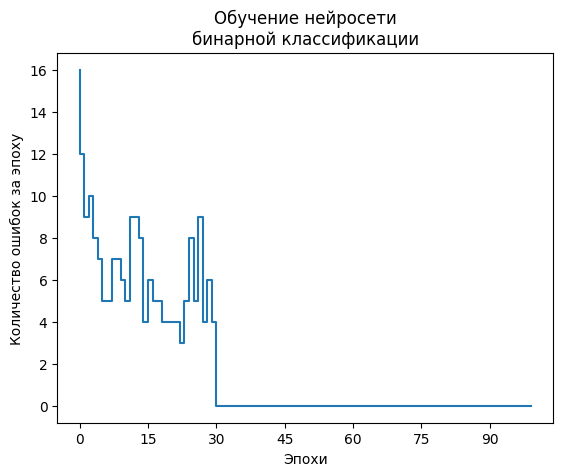

In [145]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.step([i for i in range(len(errors))], errors)

plt.xlabel("Эпохи")
plt.ylabel("Количество ошибок за эпоху")
plt.title("Обучение нейросети\nбинарной классификации")
print("Размерность слоёв: ", *[i.size for i in  MLP.layers])

In [146]:
for i in range(3):
    x_val, y_val = get_features(df, 'sex', 'male', numeric_features)
    x_val = scalers[i].transform(x_val)
    y_val_pred = percps[i].predict(x_val)

    print('')
    print('Accuracy:', acc(y_val == 1, y_val_pred == 1))
    print('Recall:', rec(y_val == 1, y_val_pred == 1))
    print('Precision:', pre(y_val == 1, y_val_pred == 1))


Accuracy: 0.8378378378378378
Recall: 0.8988095238095238
Precision: 0.8031914893617021

Accuracy: 0.7267267267267268
Recall: 0.8452380952380952
Precision: 0.6859903381642513

Accuracy: 0.6726726726726727
Recall: 0.35119047619047616
Precision: 1.0
